## Topic modelling: tests with the  Latent Dirichlet Allocation (LDA) algorithm - Gibbs sampling version.
***

### 1. Initialization of the R environment.
***
The first step is to load the required libraries. 

In [1]:
rm(list=ls()) ## clear objects from memory

options(warn = -1)

## install.packages('repr')

library(tm)
library(ggplot2)
library(textmineR)
library(tidytext)
library(dplyr)
library(tidyr)
library(repr)
library(openxlsx)

set.seed(1234)

Loading required package: NLP


Attaching package: ‘NLP’


The following object is masked from ‘package:httr’:

    content



Attaching package: ‘ggplot2’


The following object is masked from ‘package:NLP’:

    annotate


Loading required package: Matrix


Attaching package: ‘textmineR’


The following object is masked from ‘package:Matrix’:

    update


The following object is masked from ‘package:stats’:

    update



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack




### 2. Data input.
***

We read two of the files extracted from the database, with the glossary articles definitions in _ESTAT_dat_concepts_2021_04_08.csv_ and their titles in _ESTAT_dat_link_info_2021_04_08.csv_. The common key is _id_. **At a later stage, the reading of the files will be directly from the KD**. 

We then drop articles with missing titles and/or definitions and also de-duplicate the records of the resulting file based on these two fields.



In [2]:
dat1 <- read.csv2('../input/lda-data/ESTAT_dat_concepts_2021_04_08.csv')
dat2 <- read.csv2('../input/lda-data/ESTAT_dat_link_info_2021_04_08.csv')
dat <- merge(dat1,dat2,by=c('id'),all=FALSE)
dat <- dat[,c('id','title','definition')]

dels <- which(is.na(dat$title))
if(length(dels)>0) dat <- dat[-dels,]

dels <- which(is.na(dat$definition))
if(length(dels)>0) dat <- dat[-dels,]

dels <-which(duplicated(dat$title))
if(length(dels)>0) dat <- dat[-dels,]

dels <- which(duplicated(dat$definition))
if(length(dels)>0) dat <- dat[-dels,]

rm(dat1,dat2)


### 3. Data cleaning.
***

In the next step we do some data cleaning: 

* Replace multiple spaces with single ones in definitions.
* Discard spaces at the start of definitions and titles. 
* Replace space-comma-space by comma-space in definitions.


In [3]:
dat$definition <- gsub(' +',' ',dat$definition) ## discard multiple spaces
dat$definition <- gsub('^ +','',dat$definition) ## discard spaces at start
dat$definition <- gsub(' \\, ','\\, ',dat$definition) ## space-comma-space -> comma-space

dat$title <- gsub('^ +','',dat$title) ## discard spaces at start


### 4. Creating the Document-Term Matrix.
***

Next we create a document-term matrix (DTM) _texts_ from the articles. This has initially 1285 rows / text entries. When creating the DTM matrix, we apply some standard pre-processing steps:

* Remove punctuation and numbers. 
* Convert all terms to lower case.
* Remove stop words.
* Strip whitespace and apply an English stemmer (Porter's stemmer).

The initial number of terms is 5483. We then delete terms with length less than 5 and we keep terms which are in at least 2% and in at most 30% of the documents. We remove documents without terms and we end up with 1281 documents and 467 terms.


In [4]:
texts <- CreateDtm(dat$definition,doc_names=dat$title, ngram_window = c(1, 1),
stopword_vec = c(stopwords::stopwords("en"),
stopwords::stopwords(source = "smart")), lower = TRUE,
remove_punctuation = TRUE, remove_numbers = TRUE,
stem_lemma_function =  function(x) SnowballC::wordStem(x, "porter"), verbose = TRUE)

texts@Dim

ndocs <- nrow(texts) ; nterms <- ncol(texts)
cat('docs = ',ndocs,' terms = ',nterms, '\n')

## min word length: 5, each term in at least 2% of documents 
## and at most in 30% of documents
dels <- which(nchar(texts@Dimnames[[2]]) < 5)
if(length(dels)>0) texts <- texts[,-dels]

dels <- which(colSums(texts) < 0.02*nrow(texts))
if(length(dels)>0) texts <- texts[,-dels]
dels <- which(colSums(texts) > 0.3*nrow(texts))
if(length(dels)>0) texts <- texts[,-dels]

dels <- which(rowSums(texts)==0) #remove all texts without terms 
              
if(length(dels)>0) {
  texts   <- texts[-dels, ]           
  dat <- dat[-dels,]
}

texts@Dim

[1] 1285 5469

docs =  1285  terms =  5469 


[1] 1281  467

We apply the LDA algorithm with Gibbs sampling, _k_=20 topics and a sufficient number of iterations (500) of the Gibbs sampler. We do not take into account the first 400 iterations in the results, in order to avoid transient values in the maximization of the log-likelihood (see plot in the next chunk).  

Function _FitLdaModel()_ returns an object which contains, among others, a matrix _theta_ expressing, for each topic and term, the **probability that the term is generated from the specific topic**. For details, see [R package textmineR](https://cran.r-project.org/web/packages/textmineR/index.html). More specifically, the return value contains three matrices:

* $theta: P(topic_k|document_d)$
* $phi: P(token_v|topic_k)$
* $gamma: P(topic_k|token_v)$ 

In the following code, we also plot the Gibbs sampling iterations. 

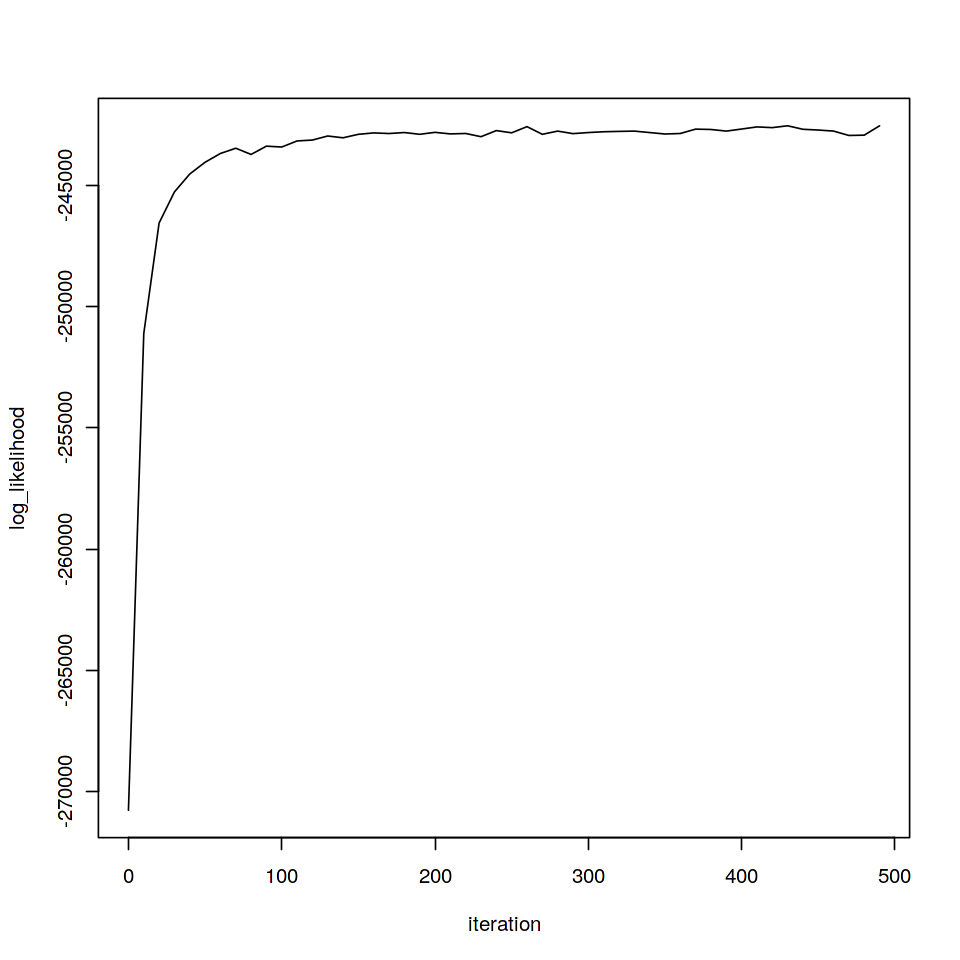

In [5]:
options(repr.plot.width = 8, repr.plot.height = 8)

lda_model <- 
  FitLdaModel(texts, k=20, iterations = 500, burnin = 400, alpha = 0.1,
beta = 0.05, optimize_alpha = TRUE, calc_likelihood = TRUE,
calc_coherence = TRUE, calc_r2 = FALSE)

#print(lda_model$log_likelihood)
plot(lda_model$log_likelihood, type = "l")




Next, we first group the results by topic and then select the terms with the top _phi_ values in each topic.Then we plot these values and the corresponding terms for each topic. _phi_ is renamed to _beta_ in these plots to keep the conventions in _tidytext_.

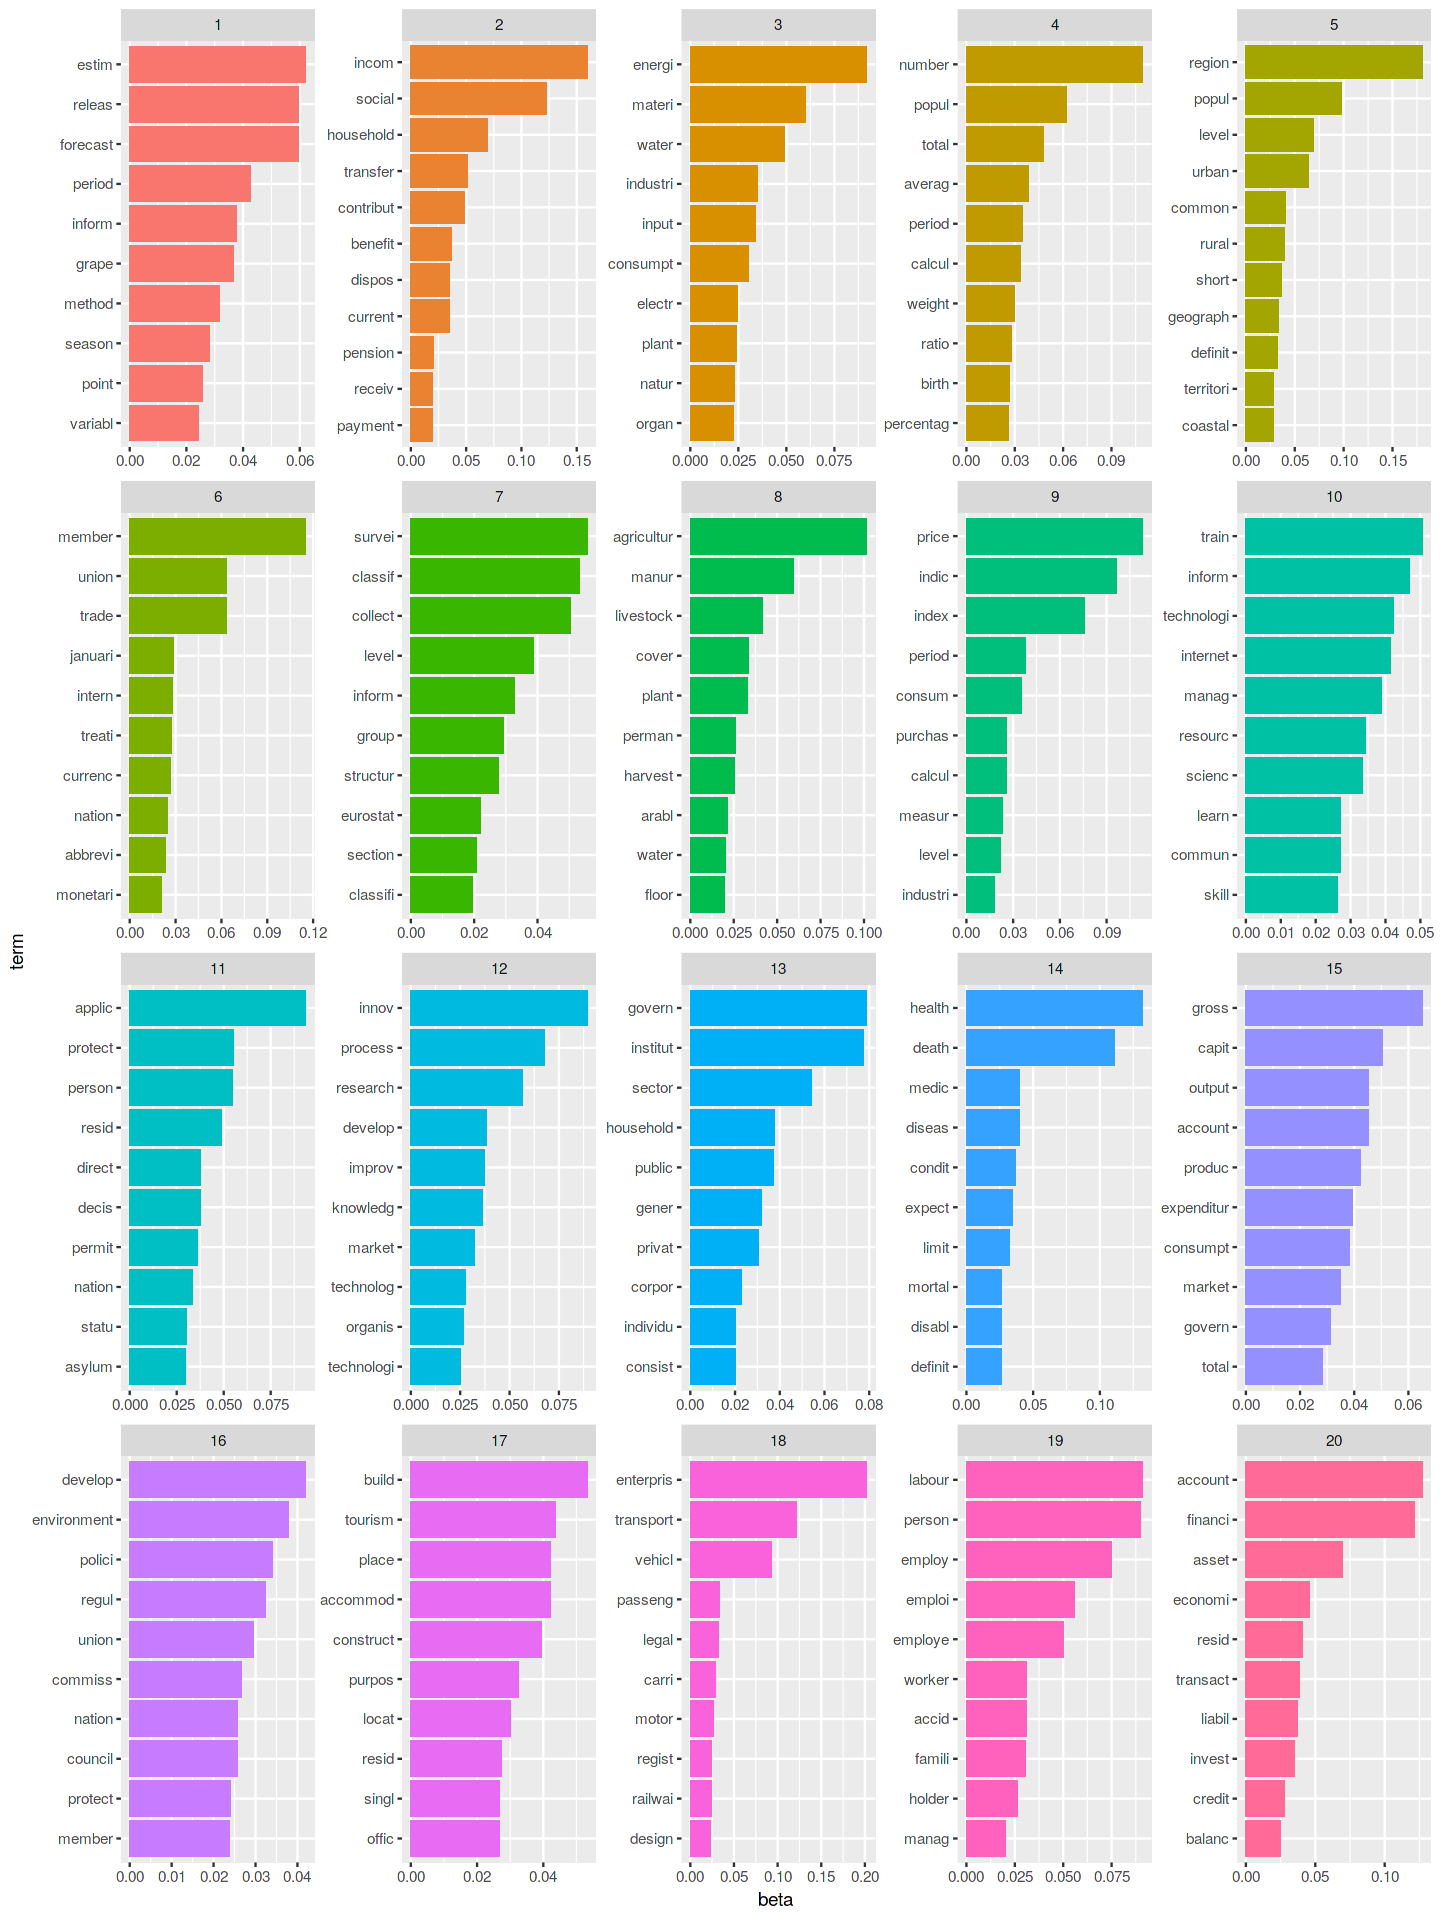

In [6]:
options(repr.plot.width = 12, repr.plot.height = 16)

tidy_beta <- data.frame(topic = as.integer(stringr::str_replace_all(rownames(lda_model$phi), "t_", "")), 
                        lda_model$phi, stringsAsFactors = FALSE) %>%
  gather(term, beta, -topic) %>% 
  tibble::as_tibble()

  
top_terms <- tidy_beta %>%
  group_by(topic) %>%
  slice_max(beta, n = 10) %>% 
  ungroup() %>%
  arrange(topic, -beta)

top_terms %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(beta, term, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  scale_y_reordered()

The results with the top 20 terms by topic can be interpreted as follows: 
* Topic 1: Forecasting methods.
* Topic 2: Social expenditure and contributions.
* Topic 3: Energy production and consumption.
* Topic 4: Demographics.
* Topic 5: Regions, territories and geography.
* Topic 6: Intra-EU trade and treaties.
* Topic 7: Surveillance data collection. 
* Topic 8: Agriculture.
* Topic 9: Price indices.
* Topic 10: Education and training in information technology .
* Topic 11: Protection applications and asylum grants.
* Topic 12: R&D and innovation.
* Topic 13: Private and public sector institutions.
* Topic 14: Public health, diseases, morbidity and mortality.
* Topic 15: Production, consumption and gross accounts.
* Topic 16: Environmental policies and regulations.
* Topic 17: Tourism and accommodation.
* Topic 18: Transport.
* Topic 19: Persons and employment.
* Topic 20: Financial accounts and transactions.

(Continue with analyses based on the other matrices, for example the _gamma_ coefficients). 

Below, we show the top 5 topics per term.

In [7]:
tidy_beta <- data.frame(topic = as.integer(stringr::str_replace_all(rownames(lda_model$gamma), "t_", "")), 
                        lda_model$gamma, stringsAsFactors = FALSE) %>%
                        gather(term, gamma, -topic) %>% tibble::as_tibble()
top_topics <- tidy_beta  %>%
   group_by(term) %>%
   slice_max(gamma, n = 5) %>% 
    ungroup() %>%
    arrange(term,-gamma)

top_topics

topic,term,gamma
<int>,<chr>,<dbl>
16,abbrevi,0.2900522814
6,abbrevi,0.2428687080
7,abbrevi,0.1894603120
9,abbrevi,0.0753388490
3,abbrevi,0.0556773931
10,access,0.5083750081
8,access,0.2636117116
6,access,0.1405817582
17,access,0.0553023603


Apart from the three matrices, _lda_model_ contains:
* $alpha$ and $beta$: the Dirichlet priors for topics over documents and tokens over topics, respectively. 
* The _log_likelihood_: P(tokens|topics) at each iteration. 
* _coherence_ which gives the probabilistic coherence of each topic. 
* _r2_: the R-squared of the model given the data.

In [8]:
str(lda_model)

List of 8
 $ phi           : num [1:20, 1:467] 6.09e-05 2.66e-05 2.68e-05 2.31e-05 5.74e-05 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:20] "t_1" "t_2" "t_3" "t_4" ...
  .. ..$ : chr [1:467] "achiev" "acquisit" "cooper" "densiti" ...
 $ theta         : num [1:1281, 1:20] 0.00357 0.01 0.00313 0.00714 0.00769 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:1281] "Arrival of tourist at a tourist accommodation establishment" "Nights spent   " "Supply side tourism statistics   " "Tourist   " ...
  .. ..$ : chr [1:20] "t_1" "t_2" "t_3" "t_4" ...
 $ gamma         : num [1:20, 1:467] 0.00217 0.00212 0.00206 0.00201 0.00213 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:20] "t_1" "t_2" "t_3" "t_4" ...
  .. ..$ : chr [1:467] "achiev" "acquisit" "cooper" "densiti" ...
 $ data          :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:21478] 101 163 178 179 188 283 369 417 462 544 ...
  .. ..@ p       : int [1:468] 0 19 35 53 67 

In the following, we plot the **coherence** of the topics. The average of these values, called coherence score, is a usual measure for the quality of the LDA model fit.

In [9]:
topic <- paste0('t',1:20)
coherence <- lda_model$coherence
tmp <- as.data.frame(cbind(topic,coherence),stringsAsFactors=FALSE)
tmp$coherence <- as.numeric(tmp$coherence)
tmp$topic <- factor(tmp$topic,levels=tmp$topic)
print(tmp)

cat('\nCoherence score: ',mean(coherence),'\n')

     topic  coherence
t_1     t1 0.16281340
t_2     t2 0.17811114
t_3     t3 0.12057394
t_4     t4 0.12532880
t_5     t5 0.16204112
t_6     t6 0.16088671
t_7     t7 0.19599472
t_8     t8 0.14579802
t_9     t9 0.16216286
t_10   t10 0.09465272
t_11   t11 0.07403901
t_12   t12 0.20614322
t_13   t13 0.18285828
t_14   t14 0.17831202
t_15   t15 0.23967003
t_16   t16 0.15327378
t_17   t17 0.11169707
t_18   t18 0.05887436
t_19   t19 0.23523834
t_20   t20 0.13224685

Coherence score:  0.1540358 


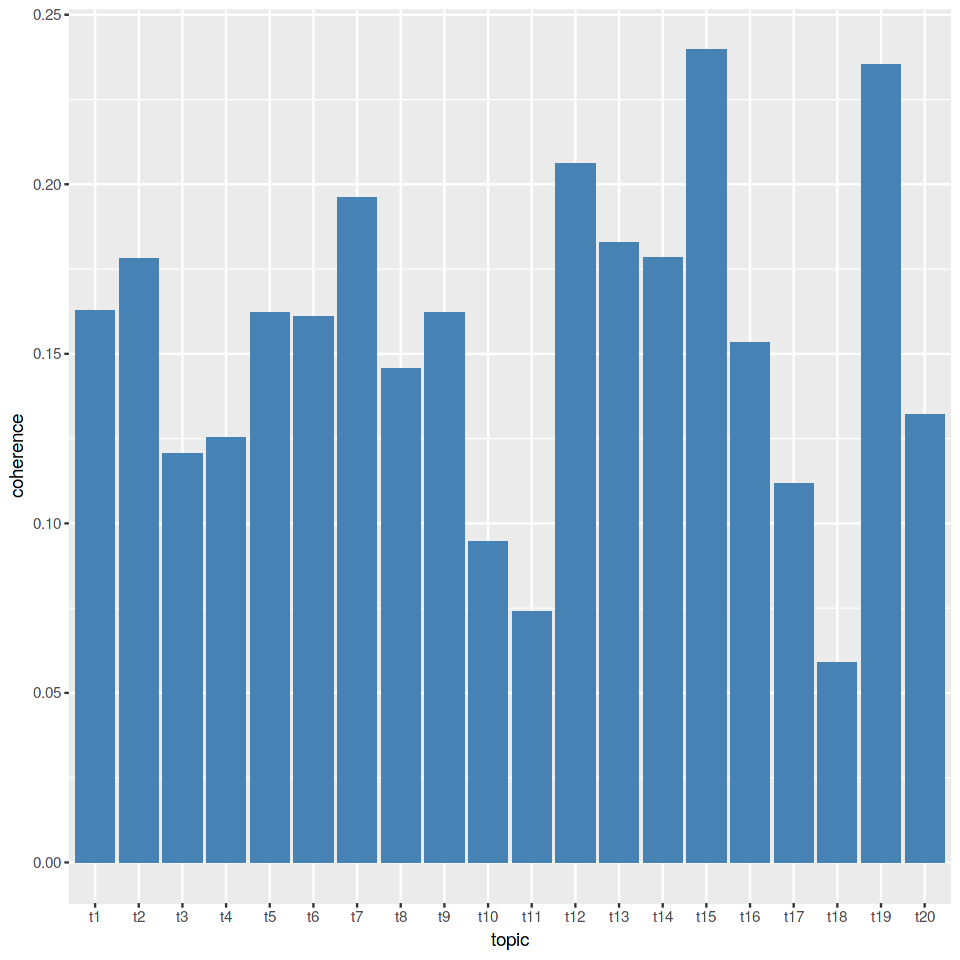

In [10]:
options(repr.plot.width = 8, repr.plot.height = 8)
p <- ggplot(data=tmp, aes(x=topic,y=coherence)) +
  geom_bar(stat="identity", fill= "steelblue")
p

### 6. Documents and topics.
***
In the following, we create a file output with the posterior probabilities of topics contributing to articles. We set a threshold of 0.3 for these probabilities to be shown.

In [11]:

##most likely topics for each document.
topic_titles <- c(
 'Forecasting methods',
'Social expenditure and contributions',
'Energy production and consumption',
'Demographics',
'Regions, territories and geography',
'Intra-EU trade and treaties',
'Surveillance data collection', 
'Agriculture',
'Price indices',
'Education and training in information technology',
'Protection applications and asylum grants',
'R&D and innovation',
'Private and public sector institutions',
'Public health, diseases, morbidity and mortality',
'Production, consumption and gross accounts',
'Environmental policies and regulations',
'Tourism and accommodation',
'Transport',
'Persons and employment',
'Financial accounts and transactions')
    
 
docs_topics <- as.data.frame(cbind(dat[,c('id','title')]))
for(j in 1:20)
    docs_topics[,paste0('T',j,'_',topic_titles[j])] <- NA

for(row in 1:nrow(docs_topics))
    for(col in 1:20) {
        val <- lda_model$theta[row,col]
        if(lda_model$theta[row,col] >= 0.3) docs_topics[row,2+col] <- lda_model$theta[row,col]
    }

docs_topics


,id,title,T1_Forecasting methods,T2_Social expenditure and contributions,T3_Energy production and consumption,T4_Demographics,"T5_Regions, territories and geography",T6_Intra-EU trade and treaties,T7_Surveillance data collection,T8_Agriculture,⋯,T11_Protection applications and asylum grants,T12_R&D and innovation,T13_Private and public sector institutions,"T14_Public health, diseases, morbidity and mortality","T15_Production, consumption and gross accounts",T16_Environmental policies and regulations,T17_Tourism and accommodation,T18_Transport,T19_Persons and employment,T20_Financial accounts and transactions
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,Arrival of tourist at a tourist accommodation establishment,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,0.8964286,NA,NA,NA
2,3,Nights spent,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,0.8100000,NA,NA,NA
3,4,Supply side tourism statistics,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,0.6906250,NA,NA,NA
4,5,Tourist,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,0.7928571,NA,NA,NA
5,7,Asia-Europe Meeting (ASEM),NA,NA,NA,NA,NA,0.8538462,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,9,Association of South East Asian Nations (ASEAN),NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,0.8272727,NA,NA,NA,NA
7,10,European Free Trade Association (EFTA),NA,NA,NA,NA,NA,0.8366667,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
8,11,European Union (EU),NA,NA,NA,NA,NA,0.9173913,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
9,12,Northeast and South Asia (NESA),NA,NA,NA,NA,NA,0.3666667,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [12]:
write.xlsx(docs_topics,'docs_topics_2.xlsx')